# Deutsch-Jozsa Algorithm

> **The Deutsch–Jozsa algorithm** [\[1\]](#ref-original-paper), [\[2\]](#DJWiki), named after David Deutsch and Richard Jozsa, is one of the first fundamental quantum algorithms showing exponential speedup over its classical counterpart$^*$. While it has no practical applicative use, it serves as a toy model for quantum computing, demonstrating how the concepts of superposition and interference enable quantum algorithms to outperform classical ones.
>
> The algorithm treats the following problem:
>
> - **Input:** A black box Boolean function $f(x)$ that acts on the integers in the range $[0, 2^{n}-1]$.
> - **Promise:** The function is either constant or balanced (for half of the values it is 1 and for the other half it is 0).
> - **Output:** Whether the function is constant or balanced.
>
> **Complexity:** The quantum approach requires a single query. If we require a deterministic answer to the problem, classically, we must inquire of the oracle $2^{n-1}+1$ times in the worst case. Therefore, the quantum algorithm exhibits a clear exponential speedup. However, without requiring deterministic determination—namely, allowing application of the classical probabilistic algorithm to get the result up to some error—then the exponential speedup is lost: taking $k$ classical evaluations of the function $f$ determines whether the function is constant or balanced, with a probability of $1 - 1/2^k$.
>
> $^*$ The exponential speedup is in the oracle complexity setting. It only refers to deterministic classical machines.
>
> ---
>
> **Keywords:** Foundational quantum algorithms, Phase oracle, Function evaluation, Oracle problem, Oracle/Query complexity.


We define the Deutsch-Jozsa algorithm, which has a [quantum part](#The-Quantum-Part) and a [classical postprocess part](#The-Classical-Postprocess). Then, we run the algorithm on two different examples, one with a [simple](#Example:-Simple-Arithmetic-Oracle) $f(x)$ and another that is [more complex](#Example:-Complex-Arithmetic-Oracle). A [mathematical explanation](#Technical-Notes) of the algorithm is provided at the end of this notebook.

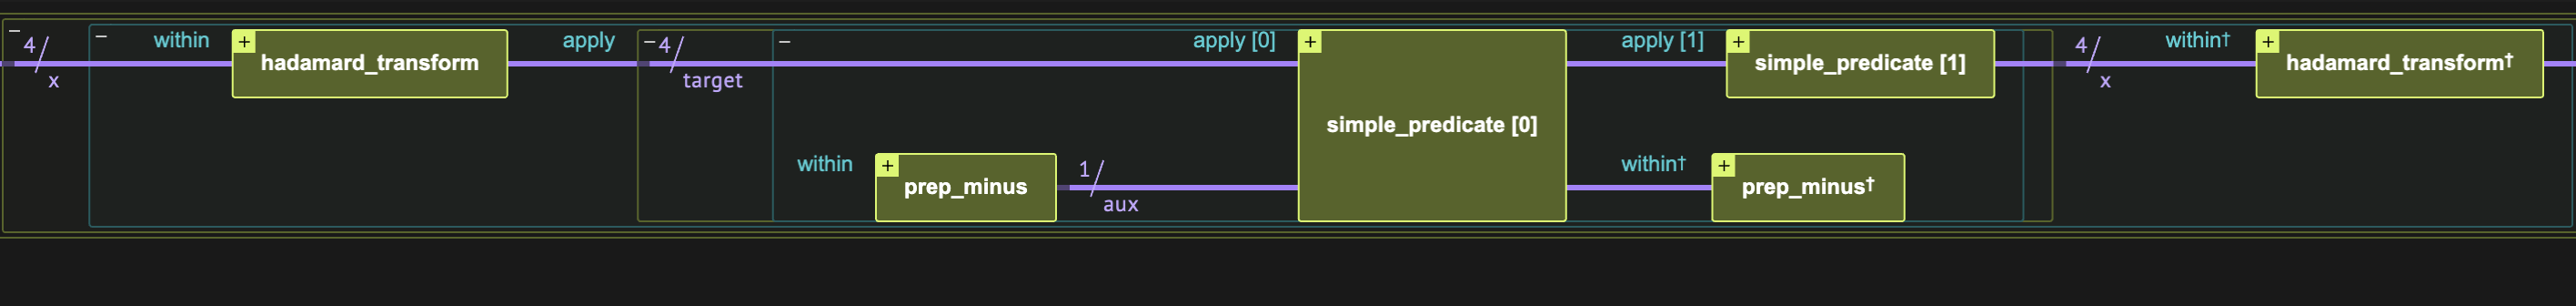
<center>
<figcaption align = "middle"> Figure 1. The Deutsch-Jozsa algorithm </figcaption>
</center>

## How to Build the Algorithm with Classiq

We define a `deutsch_jozsa` quantum function whose arguments are a quantum function for the black box $f(x)$, and a quantum variable on which it acts, $x$. The Deutsch-Jozsa algorithm is composed of three quantum blocks (see Figure 1): a Hadamard transform, an arithmetic oracle for the black box function, and another Hadamard transform. 

### The Quantum Part

In [1]:
from classiq import *


@qfunc
def deutsch_jozsa(predicate: QCallable[QNum, QBit], x: QNum) -> None:
    within_apply(
        lambda: hadamard_transform(x),
        lambda: phase_oracle(predicate=lambda x, y: predicate(x, y), target=x),
    )

### The Classical Postprocess

The classical part of the algorithm reads: The probability of measuring the $|0\rangle_n$ state is 1 if the function is constant and 0 if it is balanced. 
We define a classical function that gets the execution results from running the quantum part and returns whether the function is constant or balanced:

In [2]:
def post_process_deutsch_jozsa(parsed_results):
    if len(parsed_results) == 1:
        if 0 not in parsed_results:
            print("The function is balanced")
        else:
            print("The function is constant")
    else:
        print(
            "cannot decide as more than one output was measured, the distribution is:",
            parsed_results,
        )

## Example: Simple Arithmetic Oracle

We start with a simple example on $n=4$ qubits, and $f(x)= x >7$. Classically, in the worst case, the function should be evaluated $2^{n-1}+1=9$ times. However, with the Deutsch-Jozsa algorithm, this function is evaluated only once.

We build a predicate for this specific use case:

In [3]:
@qperm
def simple_predicate(x: Const[QNum], res: QBit) -> None:
    res ^= x > 7

Next, we define a model by inserting the predicate into the `deutsch_jozsa` function:

In [4]:
NUM_QUBITS = 4


@qfunc
def main(x: Output[QNum[NUM_QUBITS]]):
    allocate(x)
    deutsch_jozsa(lambda x, y: simple_predicate(x, y), x)


write_qmod(main, "simple_deutsch_jozsa")
qprog_1 = synthesize(main)

Finally, we execute and call the classical postprocess:

In [5]:
result_1 = execute(qprog_1).result_value()
results_list_1 = [sample.state["x"] for sample in result_1.parsed_counts]
post_process_deutsch_jozsa(results_list_1)

The function is balanced


In [6]:
show(qprog_1)

Quantum program link: https://platform.classiq.io/circuit/34bVikTQl9GLdAJDoA3darxeyCH


## Example: Complex Arithmetic Oracle

*Generalizing to more complex scenarios makes no difference for modeling*. Let us take a complicated function, working with $n=3$: a function $f(x)$ that first takes the maximum between the input bitwise-xor with 4 and the input bitwise-and with 3, then checks whether the result is greater or equal to 4. Can you tell whether the function is balanced or constant?

*This time we provide a width bound to the synthesis engine.*

We follow the three steps as before:

In [7]:
from classiq.qmod.symbolic import max

NUM_QUBITS = 3


@qperm
def complex_predicate(x: Const[QNum], res: QBit) -> None:
    res ^= max(x ^ 4, x & 3) >= 4


@qfunc
def main(x: Output[QNum[NUM_QUBITS]]):
    allocate(x)
    deutsch_jozsa(lambda x, y: complex_predicate(x, y), x)


write_qmod(main, "complex_deutsch_jozsa")
qprog_2 = synthesize(
    model=main,
    constraints=Constraints(max_width=19),
)

result_2 = execute(qprog_2).result_value()
results_list_2 = [sample.state["x"] for sample in result_2.parsed_counts]
post_process_deutsch_jozsa(results_list_2)

The function is balanced


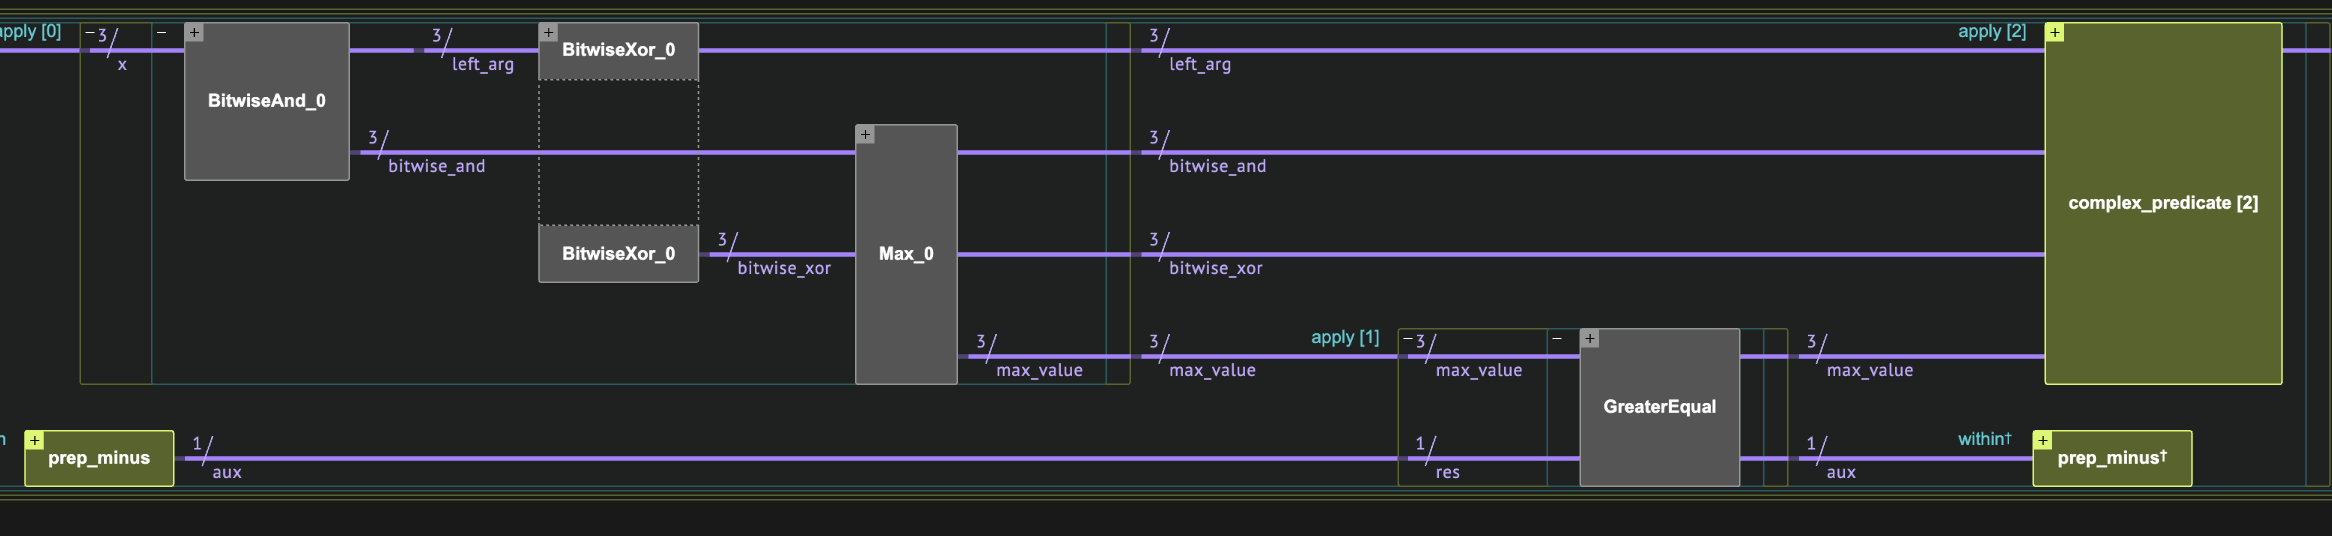
<center>
<figcaption align = "middle"> Figure 2. The Deutsch-Jozsa algorithm for the complex example, focusing on oracle implementation (the last block performs uncomputation). </figcaption>
</center>

We can visualize the circuit obtained from the synthesis engine. Figure 2 presents the complex structure of the oracle, generated automatically by the synthesis engine.

In [8]:
show(qprog_2)

Quantum program link: https://platform.classiq.io/circuit/34bVjr59eM7JAd2uyXu50Z0iIFt


## Technical Notes

A brief summary of the linear algebra behind the Deutsch-Jozsa algorithm. The first Hadamard transformation generates an equal superposition over all the standard basis elements:
$$
|0\rangle_n \xrightarrow[H^{\otimes n}]{} \frac{1}{2^{n/2}}\sum^{2^n-1}_{j=0}|j\rangle_n.
$$
The arithmetic oracle gets a Boolean function and adds an $e^{\pi i}=-1$ phase to all states for which the function returns true:
$$
\frac{1}{2^{n/2}}\sum^{2^n-1}_{j=0}|j\rangle_n \xrightarrow[\text{Oracle}(f(j))]{}\frac{1}{2^{n/2}}\sum^{2^n-1}_{j=0}(-1)^{f(j)}|j\rangle_n.
$$
Finally, applying the Hadamard transform, which can be written as $H^{\otimes n}\equiv \frac{1}{2^{n/2}}\sum^{2^n-1}_{k,l=0}(-1)^{k\cdot l} |k\rangle \langle l| $, gives
$$
\frac{1}{2^{n/2}}\sum^{2^n-1}_{j=0}(-1)^{f(j)}|j\rangle  \xrightarrow[H^{\otimes n}]{} 
\sum^{2^n-1}_{k=0} \left(\frac{1}{2^{n}}\sum^{2^n-1}_{j=0}(-1)^{f(j)+j\cdot k} \right) |k\rangle.
$$

The probability of getting the state $|k\rangle = |0\rangle$ is
$$
P(0)=\left|\frac{1}{2^{n}}\sum^{2^n-1}_{j=0}(-1)^{f(j)} \right|^2 =
\left\{
\begin{array}{l l}
1 & \text{if } f(x) \text{ is constant} \\
0 & \text{if } f(x) \text{ is balanced.}
\end{array}
\right.
$$

<h3 id="references">References</h3>
<ol>
  <li id="ref-original-paper">
    David Deutsch & Richard Jozsa. Rapid solutions of problems by quantum computation. Proceedings of the Royal Society of London A. 439 (1907): 553–558. (1992).
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://royalsocietypublishing.org/doi/10.1098/rspa.1992.0167" target="_blank" rel="noopener noreferrer">DOI &#8599;</a>
  <li id="DJWiki">
    Deutsch Jozsa.
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://en.wikipedia.org/wiki/Deutsch%E2%80%93Jozsa_algorithm" target="_blank" rel="noopener noreferrer">(Wikipedia) &#8599;</a>
</ol>
